# Salary prediction via Deep NLP methods
A recent Kaggle competiton (merely 5 years) propose you to find out who is the most well-paid professional

We are gonna solve regression task.

Competition is available here: https://www.kaggle.com/c/job-salary-prediction

![Hobby](https://imgs.xkcd.com/comics/extrapolating.png)

In this notebook you will learn
 - Data preprocessing for NLP or the most annoying part of data scientist's job
 - Convolutional Neural Networks for texts
 - Constructing you NN with scripting

# Data

Dataset is consists of job data. Most of it is an unstructured text. You should predict annual salary

Download here: https://yadi.sk/d/vVEOWPFY3NruT7 or from competition

## Main fields

Title - A freetext field supplied to us by the job advertiser as the Title of the job ad.  Normally this is a summary of the job title or role.

FullDescription - The full text of the job ad as provided by the job advertiser.  Where you see ***s, we have stripped values from the description in order to ensure that no salary information appears within the descriptions.  There may be some collateral damage here where we have also removed other numerics.

LocationRaw - The freetext location as provided by the job advertiser.

LocationNormalized - Adzuna's normalised location from within our own location tree, interpreted by us based on the raw location.  Our normaliser is not perfect!

ContractType - full_time or part_time, interpreted by Adzuna from description or a specific additional field we received from the advertiser.

ContractTime - permanent or contract, interpreted by Adzuna from description or a specific additional field we received from the advertiser.

Company - the name of the employer as supplied to us by the job advertiser.

Category - which of 30 standard job categories this ad fits into, inferred in a very messy way based on the source the ad came from.  We know there is a lot of noise and error in this field.

## Desiered field
SalaryRaw - the freetext salary field we received in the job advert from the advertiser.


In [3]:
import pandas as pd
import numpy as np
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
X = pd.DataFrame.from_csv('Train_rev1.csv', index_col=None)
X.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


In [5]:
X.ContractType = X.ContractType.astype(str)
X.ContractTime = X.ContractTime.astype(str)
X.Company = X.Company.astype(str)

In [6]:
Y = X['SalaryNormalized'].copy()

In [7]:
del X['Id'], X['Title'],  X['SalaryRaw'], X['SourceName'], X['SalaryNormalized']

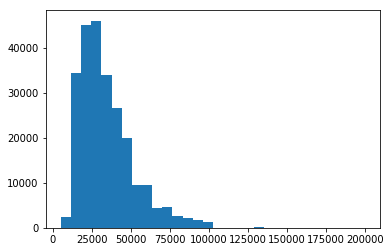

In [8]:
_ = plt.hist(Y, bins=30)

# Preprocessing
At this very stage we will distill valuable data out of the dataset

First of all - let's remove rare tokens and finalaize our dictionary

We count all tokens ever occurred in data

In [9]:
text_columns = list(X.columns)
print (text_columns)
categorial_colums = ['ContractType',
 'ContractTime',
 'Company',
 'Category']

['FullDescription', 'LocationRaw', 'LocationNormalized', 'ContractType', 'ContractTime', 'Company', 'Category']


Your code is below. 

ember to apply .lower() to all strings before tokenization

Consider using tqdm_notebook for not dying  during the iteration process

In [10]:
from nltk.tokenize import RegexpTokenizer
from collections import Counter,defaultdict
tokenizer = RegexpTokenizer(r"\w+|\d+")

#Dictionary of tokens
token_counts = Counter()

def tokenize(value):
    return tokenizer.tokenize(value.lower())

for col in text_columns:
    for text in tqdm.tqdm(X[col]):
        token_counts.update(tokenize(text))
        

100%|██████████| 244768/244768 [00:01<00:00, 204651.38it/s]


In [11]:
assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Correct!


Now is the time to actually build token dict. We will use only words that occur more than `min_count` times in dataset

Fill two mappings id->token and token->id

**Minimum id is 2**, because 0 is reserved for padding and 1 is UNK

In [12]:
min_count = 10

tokens = [w for w, c in token_counts.items() if c > min_count] 
#<tokens from token_counts keys that had at least min_count occurrences throughout the dataset>

In [13]:
assert type(tokens)==list
#assert len(tokens)==33497
assert 'me' in tokens
print("Correct!")

Correct!


In [14]:
dict_size = len(tokens)+2
id_to_word = dict()
word_to_id = dict()

# <your code here>
token_to_id = {t:i+2 for i,t in enumerate(tokens)}

id_to_token = {i+2:t for i,t in enumerate(tokens)}

In [15]:
assert token_to_id['me'] != token_to_id['woods']
assert token_to_id[id_to_token[42]]==42
assert len(token_to_id)==len(tokens)
assert 0 not in id_to_token

In [16]:
def vectorize(strings, token_to_id, UNK=1, PAD=0):
    '''This function gets a string array and transforms it to padded token matrix
    Remember to:
     - Transform a string to list of tokens
     - Transform each token to it ids (if not in the dict, replace with UNK)
     - Pad each line to max_len'''
    token_matrix = []
    
    for s in strings:
        seq = [token_to_id.get(token,UNK) for token in tokenize(s)]
        token_matrix.append(seq)
    
    max_len = max(map(len,token_matrix))
        
    # handle empty batch
    if max_len == 0:
        max_len = 1
    
    for i in range(len(token_matrix)):
        while(len(token_matrix[i]) < max_len):
            token_matrix[i].append(PAD)
    
    return np.array(token_matrix)

In [17]:
test = vectorize(["Hello, adshkjasdhkas", "data"], token_to_id, 1)
assert test.shape==(2,2)
assert (test[:,1]==(1,0)).all()
print("Correct!")

Correct!


In [18]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 1000)

**If you successfully completed all tasks by this moment, you ger 3 pts**

# True deep learning

Now we will define our convolutional neural network.

We will think about categorical fields as a sequential - but we won't apply CNN to them

In [19]:
%env CUDA_VISIBLE_DEVICES = ""
import theano.tensor as T
import theano
import lasagne

env: CUDA_VISIBLE_DEVICES=""


Initialaize some placeholders for data

What size it should  be?

In [54]:
placeholders = dict()
for col in text_columns:
    placeholders[col] = T.matrix(col,dtype='int32')
    
true_y = T.vector(dtype='float32')

Embeddings are vector represetations for tokens. Basically it is just a table where each token (represented by it's id) has a vector representing its sense.

It will be learned simultaneously with other layers

In [21]:
embeddings_size = 50


## Deep nets
Below we are gonna define some network architectures corresponding to each input (a column from a source data)

In [108]:
def dream_neural_net(word_ids, name):
    
    output = lasagne.layers.InputLayer([None, None], word_ids)
    output = lasagne.layers.EmbeddingLayer(output, input_size=dict_size, output_size=embeddings_size)
    output = lasagne.layers.DimshuffleLayer(output, [0,2,1])
    #output = lasagne.layers.Conv1DLayer(output, num_filters=8, filter_size=3, pad='same')
    #output = lasagne.layers.MaxPool1DLayer(output, pool_size=3)
    #output = lasagne.layers.GlobalPoolLayer(output)
        
    return output

In [109]:
def dream_neural_net_categorial(word_ids, name):
    output = lasagne.layers.InputLayer([None, None], word_ids)
    output = lasagne.layers.EmbeddingLayer(output, input_size=dict_size, output_size=embeddings_size)
    output = lasagne.layers.DimshuffleLayer(output, [0,2,1])
    #output = lasagne.layers.DenseLayer(output, num_units=8, nonlinearity=T.nnet.relu)
    return output

Now it is time to combine all architectures. In a dict below you can match input type and an architecture

In [110]:
nets_types = {'FullDescription': dream_neural_net, 
 'LocationRaw': dream_neural_net, 
 'LocationNormalized': dream_neural_net, 
 'ContractType': dream_neural_net_categorial, 
 'ContractTime': dream_neural_net_categorial, 
 'Company': dream_neural_net_categorial, 
 'Category':dream_neural_net_categorial
}

In [111]:
outputs_to_concat = [nets_types[name](word_ids, name) for name, word_ids in placeholders.items()]
dense_repr = lasagne.layers.ConcatLayer(outputs_to_concat, axis=1)
#[print(name, word_ids) for name, word_ids in placeholders.items()]

In [112]:
outputs_to_concat[0].output_shape, outputs_to_concat[5].output_shape

((None, 50, None), (None, 50, None))

In [113]:
assert len(dense_repr.output_shape)==2

AssertionError: 

In [ ]:
def reduce_to_number(dense_inputs):
    <YOUR CODE HERE>
    output = lasagne.layers.DenseLayer(output,<YOUR CODE HERE>)
    return output

In [ ]:
net_output = reduce_to_number(dense_repr)
predicted_y = lasagne.layers.get_output(net_output)

In [ ]:
predicted_y = predicted_y.ravel()

## Optimization
Remember - we have a regression task, what would be the loss?

Also we will estimate a target metric for a competition - **Mean absolute error**

In [ ]:
loss = T.mean((predicted_y - true_y)**2)
mean_abs_error = T.mean(T.abs_(predicted_y - true_y))

In [ ]:
optimizer = lasagne.updates.adam(loss, lasagne.layers.get_all_params(net_output)) # <your code here>

train_op = theano.function(list(placeholders.values())+[true_y], [loss, mean_abs_error], updates=optimizer )

In [ ]:
validate_op = theano.function(list(placeholders.values())+[true_y], [loss, mean_abs_error] )

## Training process

The last thing before we can run the whole monster - define train process

In [ ]:
batch_size = 5

In [ ]:
def iterate_batches(X, Y=None):
    """Takes a part of pandas DF
    Returns a pair or only X_batch, where X_batch is a dict {key: value} - where a key is name of column, 
    and a value is a matrix which will be passed to corresponding input
    """
    size = len(X)
    i = 0
    while i < len(X):
        <YOUR CODE HERE>
        
        if Y is None:
            yield X_batch 
        else:
            yield X_batch, Y_batch
        i+=batch_size

In [ ]:
def get_inputs(X_batch,Y_batch=None):
    feed_dct = [X_batch[k].astype('int32') for k in text_columns]
    if Y_batch is not None:
        feed_dct.append(Y_batch.astype('int32'))
    return feed_dct

In [ ]:
def validate():
    MSE, AE = 0, 0
    batches = 0
    <YOUR CODE HERE>
    MSE/=batches
    AE/=batches
    return (MSE, AE)

In [ ]:
def predict(X):
    return sess.run(predicted_y, get_dict(X))

In [ ]:
for first_batch in iterate_batches(X_train, Y_train):
    break
assert len(first_batch) == 2
assert type(first_batch[0]) == dict
assert first_batch[1].shape[0]==batch_size
assert np.unique([inp.shape[0] for inp in first_batch[0].values()])==batch_size
print("Correct!")

In [ ]:
MSE, AE = validate()
assert MSE < 1e10
assert AE < 50000
print

In [ ]:
AE

Define some hyper-params

In [ ]:
total_batches = len(X_train)/batch_size
num_epochs = 5

## Train
Finally it is time to run training

First, shuffle the data


By the way, if the trainig processes starts and you achive at leasrt **20k** AE error on validation, you get additional **(3 pts)**

In [ ]:
MSE, AE = validate()
assert AE < 20000
print ("I earned 3 pts with %s absolute error!" % AE)

In [ ]:
p = np.random.permutation(len(X_train))
X_train = X_train.iloc[p]
Y_train = Y_train.iloc[p]

In [ ]:
for j in range(num_epochs):
    for i, (X_batch, Y_batch) in  enumerate(iterate_batches(X_train, Y_train)):
        current_loss, abs_error =  train_op(*get_inputs(X_batch,Y_batch))
        print "Current step: %s. Current loss is %s. Absolute error is %s" % (j, current_loss, abs_error)
        if i%30==0:
            print("Validation. MSE: %s, AE: %s" % validate())

# Further experiments and home assignment
 - **(1 pt)** Add visualisation of train and val loss. Try to use some smoothing to make plots more readable 
 - **(1 pt)** Try different CNN architectures. Vary kernel size, number of filters. Find out if there is some change to a training process.
 - Try to use different architectures for different inputs. Maybe a smaller architecture would be fine for description field and more complex for a title.
 - Find out the best **embedding size** value 
 - Add dropout, and some regularisation 
 
 **(2++ pts) for all experimenting**

# See in the next series
 - Recurrent neural networks
  - Why everybody like them
  - Why everybody hate them
 - Attention for text processing
  - How to boost your NLP model performance by implementing recent DL paper